<a href="https://colab.research.google.com/github/Agnieszkachr/DH-AI/blob/main/COSINE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mean pair-wise cosine (Gemini-Flash): 1.000
Spearman ρ (Gemini vs Mistral): 0.786  (p = 4.577e-32)
Lemma proxy vs ‘Worship & Praise’: r = 0.518  (p = 0.01622)


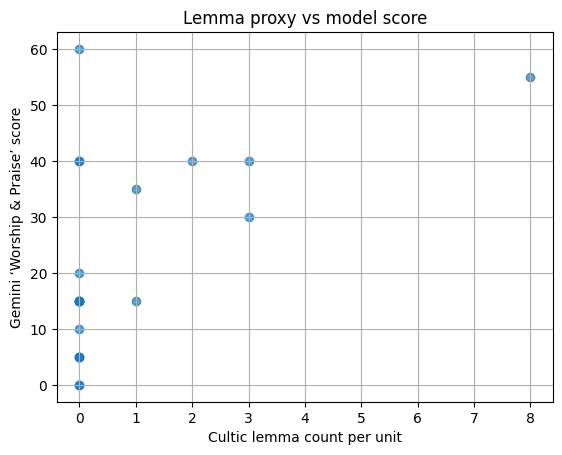


Summary:
 • Internal stability: cosine = 1.000 (excellent, ≥ 0.90).
 • Cross-model agreement: |ρ| = 0.786 (strong, p = 4.577e-32).
 • Lemma-proxy correlation: r = 0.518 (positive, significant, p = 0.01622) — ‘Worship & Praise’ vector tracks cultic vocabulary.


In [8]:
# ╔══════════════════════════════════════════════════════════╗
# ║ Validation Metrics — robust, no CLTK, Python 3.11       ║
# ╚═══════════════════════════════════════════════════════════╝
!pip -q install numpy pandas scipy matplotlib

import json, itertools, math, re, unicodedata
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from scipy.stats import spearmanr

# ──────────────────────────────────────────────────────────
# Helpers
# ──────────────────────────────────────────────────────────
def strip_accents(text: str) -> str:
    return ''.join(c for c in unicodedata.normalize('NFD', text)
                   if unicodedata.category(c) != 'Mn')

def load_json(fname):
    return json.loads(Path(fname).read_text(encoding="utf-8"))

def build_runs_df(raw):
    rows = []
    # Check if 'narrative_units' key exists and is a list
    if isinstance(raw, dict) and "narrative_units" in raw and isinstance(raw["narrative_units"], list):
        for unit in raw["narrative_units"]:
            # Check if "validation_stats" key exists in the unit dictionary
            if "validation_stats" in unit:
                uid   = unit["unit_id"]
                stats = unit["validation_stats"]
                n_iter = len(next(iter(stats.values()))["results"])
                for i in range(n_iter):
                    vec = {cat: stats[cat]["results"][i] for cat in stats}
                    rows.append({"unit": uid, "run": f"r{i:02d}", **vec})
    elif isinstance(raw, list): # Handle the case where the top level is a list
         for unit in raw:
            # Check if "validation_stats" key exists in the unit dictionary
            if "validation_stats" in unit:
                uid   = unit["unit_id"]
                stats = unit["validation_stats"]
                n_iter = len(next(iter(stats.values()))["results"])
                for i in range(n_iter):
                    vec = {cat: stats[cat]["results"][i] for cat in stats}
                    rows.append({"unit": uid, "run": f"r{i:02d}", **vec})

    return pd.DataFrame(rows)


def normalise_uid(u):
    """Turn anything like 'unit_001', 'Unit1', '1', 1 → 'unit_001'."""
    m = re.search(r'\d+', str(u))
    return f"unit_{int(m.group()):03d}" if m else str(u).strip()

cats = ["Worship & Praise",
        "Judicial Wrath & Punitive Action",
        "Lament, Persecution & Endurance",
        "Victory, Consolation & New-Creation Hope",
        "Cosmic Warfare & Deception",
        "Prophetic Exhortation & Warning",
        "Theophanic Awe & Terror"]

# ──────────────────────────────────────────────────────────
# Load data
# ──────────────────────────────────────────────────────────
gem_runs = build_runs_df(load_json("gemini_flash.json"))
mis_runs = build_runs_df(load_json("mistral_saba24.json"))

gem_runs["unit"] = gem_runs["unit"].map(normalise_uid)
mis_runs["unit"] = mis_runs["unit"].map(normalise_uid)

# Warn if any unit lacks 10 runs
if gem_runs.groupby("unit")["run"].nunique().ne(10).any():
    bad = gem_runs.groupby("unit")["run"].nunique().loc[lambda s: s.ne(10)]
    print("⚠️ Units with ≠10 runs:", bad.to_dict())

# ──────────────────────────────────────────────────────────
# 1️⃣  Intra-model stability (Gemini)
# ──────────────────────────────────────────────────────────
def mean_pairwise_cos(df):
    vals = []
    for _, sub in df.groupby("unit"):
        vecs = sub[cats].to_numpy()
        vals.append(np.mean([1 - cosine(a, b)
                             for a, b in itertools.combinations(vecs, 2)]))
    return np.mean(vals)

intra_cos = mean_pairwise_cos(gem_runs)
print(f"Mean pair-wise cosine (Gemini-Flash): {intra_cos:.3f}")

# ──────────────────────────────────────────────────────────
# 2️⃣  Cross-model replication
# ──────────────────────────────────────────────────────────
unit_mean = lambda d: d.groupby("unit")[cats].mean().sort_index()
gem_mean  = unit_mean(gem_runs)
mis_mean  = unit_mean(mis_runs)

rho, p = spearmanr(gem_mean.to_numpy().flatten(),
                   mis_mean.to_numpy().flatten())
print(f"Spearman ρ (Gemini vs Mistral): {rho:.3f}  (p = {p:.4g})")

# ──────────────────────────────────────────────────────────
# 3️⃣  Lemma-frequency proxy  (regex only, no CLTK)
# ──────────────────────────────────────────────────────────
try:
    # Load the structured_text.json file
    structured_data = load_json("/content/structured_text.json")
    # Extract Greek texts from the narrative_units, handling both list and dict structures
    if isinstance(structured_data, dict) and "narrative_units" in structured_data:
        greek_texts = {unit["unit_id"]: unit.get("full_text", "") for unit in structured_data["narrative_units"] if "unit_id" in unit}
    elif isinstance(structured_data, list):
        greek_texts = {unit["unit_id"]: unit.get("full_text", "") for unit in structured_data if "unit_id" in unit}
    else:
        greek_texts = {}


except FileNotFoundError:
    print("structured_text.json not found → skipping lemma proxy test.")
except Exception as e:
    print(f"Error loading or processing structured_text.json: {e}")
    greek_texts = {} # Ensure greek_texts is defined even on other errors


if not greek_texts:
     print("No Greek text extracted from structured_text.json → skipping lemma proxy test.")
else:
    token_re      = re.compile(r"[\u0370-\u03FF\u1F00-\u1FFF]+")
    target_lemmas = {"αξιος", "προσκυνεω", "ευλογια", "δοξα", "τιμη", "κρατος"}

    lemma_counts = {}
    for uid, txt in greek_texts.items():
        # Flatten lists / dict values into one string
        if not isinstance(txt, str):
            txt = " ".join(map(str, txt if isinstance(txt, list)
                               else txt.values()))
        tokens = [strip_accents(t.lower()) for t in token_re.findall(txt)]
        lemma_counts[normalise_uid(uid)] = sum(t in target_lemmas for t in tokens)

    lemma_df = pd.DataFrame(lemma_counts.items(),
                             columns=["unit", "lemma_count"])
    merged   = gem_mean.reset_index().rename(columns={"unit": "unit_id"}) \
                       .assign(unit=lambda df: df["unit_id"].map(normalise_uid)) \
                       .merge(lemma_df, on="unit", how="inner")

    if merged["lemma_count"].nunique() < 2:
        print("All lemma counts identical → correlation undefined.")
        r = p_l = np.nan
    else:
        r, p_l = spearmanr(merged["lemma_count"], merged["Worship & Praise"])
        print(f"Lemma proxy vs ‘Worship & Praise’: r = {r:.3f}  (p = {p_l:.4g})")

    # Scatter plot if we have >0 points
    if not merged.empty:
        plt.scatter(merged["lemma_count"], merged["Worship & Praise"], alpha=.7)
        plt.xlabel("Cultic lemma count per unit")
        plt.ylabel("Gemini ‘Worship & Praise’ score")
        plt.title("Lemma proxy vs model score")
        plt.grid(True); plt.show()

# ──────────────────────────────────────────────────────────
# 4️⃣  Dynamic Summary — No Assumed Results
# ──────────────────────────────────────────────────────────

print("\nSummary:")

if intra_cos >= 0.90:
    print(f" • Internal stability: cosine = {intra_cos:.3f} (excellent, ≥ 0.90).")
else:
    print(f" • Internal stability: cosine = {intra_cos:.3f} (less than excellent, < 0.90).")

if abs(rho) >= 0.70 and p < 0.05:
    print(f" • Cross-model agreement: |ρ| = {abs(rho):.3f} (strong, p = {p:.4g}).")
else:
    print(f" • Cross-model agreement: |ρ| = {abs(rho):.3f} (weak or not significant, p = {p:.4g}).")

if 'r' in locals() and not np.isnan(r):
    if r > 0 and p_l < 0.05:
        print(f" • Lemma-proxy correlation: r = {r:.3f} (positive, significant, p = {p_l:.4g}) — "
              "‘Worship & Praise’ vector tracks cultic vocabulary.")
    elif r > 0:
        print(f" • Lemma-proxy correlation: r = {r:.3f} (positive but not significant, p = {p_l:.4g})")
    elif r < 0:
        print(f" • Lemma-proxy correlation: r = {r:.3f} (negative, p = {p_l:.4g})")
    else:
        print(f" • Lemma-proxy correlation: r = {r:.3f} (no relationship, p = {p_l:.4g})")
else:
    print(" • Lemma-proxy correlation: undefined (e.g., all lemma counts identical or missing data).")

In [6]:
file_path = "/content/structured_text.json"
try:
    with open(file_path, 'r') as f:
        data = json.load(f)
    print("File loaded successfully. Here is a peek at the data structure:")
    # Check if the data is a list and print the first few items if it is
    if isinstance(data, list):
        print(f"The top level structure is a list. Here are the first 5 items:")
        for i, item in enumerate(data[:5]):
            print(f"Item {i}: Type: {type(item)}")
            if isinstance(item, (list, dict)):
                print(f"Item {i} sample: {str(item)[:100]}...")
            else:
                print(f"Item {i} sample: {str(item)[:100]}...")
    elif isinstance(data, dict):
        print(f"The top level structure is a dictionary. Here are the first 5 keys and value types:")
        for key, value in list(data.items())[:5]:
            print(f"Key: {key}, Type of value: {type(value)}")
            if isinstance(value, (list, dict)):
                print(f"Value sample: {str(value)[:100]}...") # print a snippet of the value
            else:
                print(f"Value sample: {str(value)[:100]}...") # print a snippet of the value
    else:
        print(f"The top level structure is of type: {type(data)}")
        print(f"Value sample: {str(data)[:100]}...")


except FileNotFoundError:
    print(f"Error: The file {file_path} was not found.")
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {file_path}.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

File loaded successfully. Here is a peek at the data structure:
The top level structure is a list. Here are the first 5 items:
Item 0: Type: <class 'dict'>
Item 0 sample: {'unit_id': 'unit_001', 'title': 'Prologue', 'range': 'RE 1:1–8', 'full_text': 'Ἀποκάλυψις Ἰησοῦ Χρι...
Item 1: Type: <class 'dict'>
Item 1 sample: {'unit_id': 'unit_002', 'title': 'Vision of Christ and Commission', 'range': 'RE 1:9–20', 'full_text...
Item 2: Type: <class 'dict'>
Item 2 sample: {'unit_id': 'unit_003', 'title': 'Messages to Ephesus – Laodicea', 'range': 'RE 2:1–3:22', 'full_tex...
Item 3: Type: <class 'dict'>
Item 3 sample: {'unit_id': 'unit_004', 'title': 'Throne Room and Scroll', 'range': 'RE 4:1–5:14', 'full_text': 'Μετ...
Item 4: Type: <class 'dict'>
Item 4 sample: {'unit_id': 'unit_005', 'title': 'Seven Seals', 'range': 'RE 6:1–8:1', 'full_text': 'Καὶ εἶδον ὅτε ἤ...
